In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.optimize import curve_fit

plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes", grid=True, linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid", ls=":", lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure", figsize=(10,3), dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major", width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major", width=1.3) #Sætter tykkelsen på xticks

In [18]:
#### paths ####
absolute_path = os.path.abspath('').rstrip("/python_notebook")

brass1p25_paths = glob.glob(absolute_path + "/Full_Sim/brass_tot_1p2mm/brass_full_1p25mm*sum.lis")
brass_paths.sort()
tungsten1p27_paths = glob.glob(absolute_path + "/Full_Sim/tungsten_tot_1.27mm/tungsten_full_1p27mm*sum.lis")
tungsten_paths.sort()








In [3]:
cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600,
    "cool8": 86400, "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, 
    "cool14": 5400, "cool15": 10800, "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150,
    "cool20": 600, "cool30": 0
}

In [4]:
def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False, number = 7) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[number])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.xlabel("A")
    plt.ylabel("Z")
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float, cool_in_sec=False) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    print("Cooling time =", df.columns.name if cool_in_sec else df.columns.name/60/60,
          "Seconds" if cool_in_sec else "Hours",
          f"| Threshold = {threshold:.0f}")
    return df_return.sort_values("Bq", ascending=False)


def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[:,i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.fillna(0)


def indv_atom(type_: str, A: str, Z: str) -> list:
    if type_ == "Brass":
        paths = brass_paths
    else:
        paths = tungsten_paths
    
    values = []
    for i in paths:
        if i == "/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis" \
        or i == "/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis":
            continue
        try:
            ff1, uncb = get_df_sum(i)
            values.append(ff1.loc[A, Z].sum())
        except Exception as e:
            print("error : ", e)
            values.append(0)
    return values


def plot_spec(type_: str, A: list, Z: list) -> None:
    
    data = pd.DataFrame(index=tungsten_t)
    for a, z in zip(A, Z):
        data[f"{a}, {z}"] = indv_atom(type_, a, z)
    data = data.sort_index()
    for i in data.columns:
        plt.plot(data.index.values/60/60, data[i].values, label=i)
    plt.title(type_)
    plt.xlabel("Hours")
    plt.ylabel("Bq")
    plt.legend()
    plt.show()
    
    return
    

def get_df_from_data(path: str, one_dim=False) -> pd.DataFrame:
    values = np.loadtxt(path)
    columns = ["z", "value", "error"] if one_dim else ["x", "y", "value", "error"]
    df = pd.DataFrame(data=values, columns=columns)
    return df
    
    
def plot_datfile(path, onedim=False) -> None:
    df = get_df_from_data(path, onedim)
    if onedim:
        plt.errorbar(df["z"].values, df["value"].values, yerr=df["error"].values, fmt="o", markersize=4, capsize=5)
        plt.show()
    else:
        data = df.pivot_table(index='x', columns='y', values='value')
        fig, ax = plt.subplots(figsize=(20, 4))
        im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=data.min().min(), vmax=data.max().max()), origin='lower')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.xlabel("A")
        plt.ylabel("Z")
        plt.colorbar(im, cax=cax)
        plt.show()

        
def get_val_unc(paths, number=7):
    times = []
    sums = []
    uncs = []

    for path in paths:
        try:
            df, unc = get_df_sum(path)
            sums.append(df.sum().sum())
            times.append(cool_times_dict[f"cool{int(path.split('_')[number])-20}"])
            df_unc = (df*unc/100)**2
            uncs.append((df_unc.sum().sum())**(1/2))
        except:
            print(path)
    
    return times, sums, uncs
    

In [5]:
tungsten_t, ds, ds = get_val_unc(tungsten_paths)

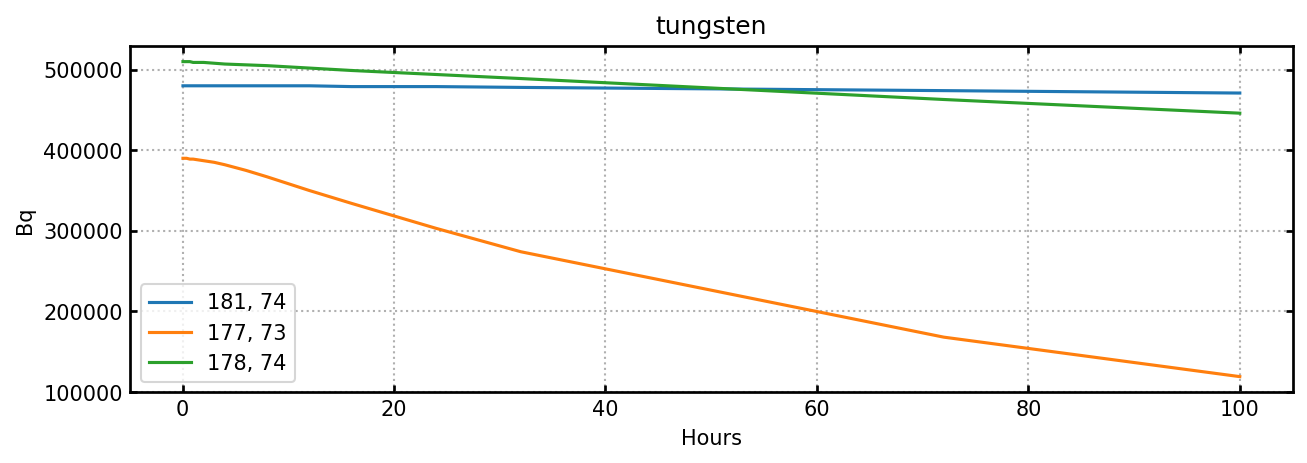

In [6]:
plot_spec("tungsten", ["181", "177", "178"], ["74", "73", "74"])

In [7]:
tot_df_tungsten, extra = get_df_sum(tungsten_paths[0])
tot_df_tungsten = sort_df(tot_df_tungsten)

for i in range(1, len(tungsten_paths)):
    path = tungsten_paths[i]
    if path == "/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis":
        continue
    df, extra = get_df_sum(path)
    tot_df_tungsten = pd.concat([tot_df_tungsten, sort_df(df)], join="inner")
    
df_sums_tungsten = pd.pivot_table(tot_df_tungsten, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
df_sums_tungsten = df_sums_tungsten.sort_values(by="Bq", ascending=False)
    
tot_df_brass, extra = get_df_sum(brass_paths[0])
tot_df_brass = sort_df(tot_df_brass)

for i in range(1, len(brass_paths)):
    path = brass_paths[i]
    if path == "/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis":
        continue
    df, extra = get_df_sum(path)
    tot_df_brass = pd.concat([tot_df_brass, sort_df(df)], join="inner")
    
df_sums_brass = pd.pivot_table(tot_df_brass, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
df_sums_brass = df_sums_brass.sort_values(by="Bq", ascending=False)   
    

#### Halflife:  (181, 74) = 121.2 days | (178, 74) = 21.6 days | (177, 73) = 56.56 hours


(                  Bq
 A   Z               
 178 74  1.001600e+07
 181 74  9.581000e+06
 177 73  6.950000e+06
 181 75  6.622800e+06
 179 74  4.886917e+06
 7   4   4.154000e+06
 183 75  3.723000e+06
 177 74  3.668569e+06
 176 73  3.153522e+06
 185 74  2.346000e+06,
 <Axes: xlabel='A,Z'>)

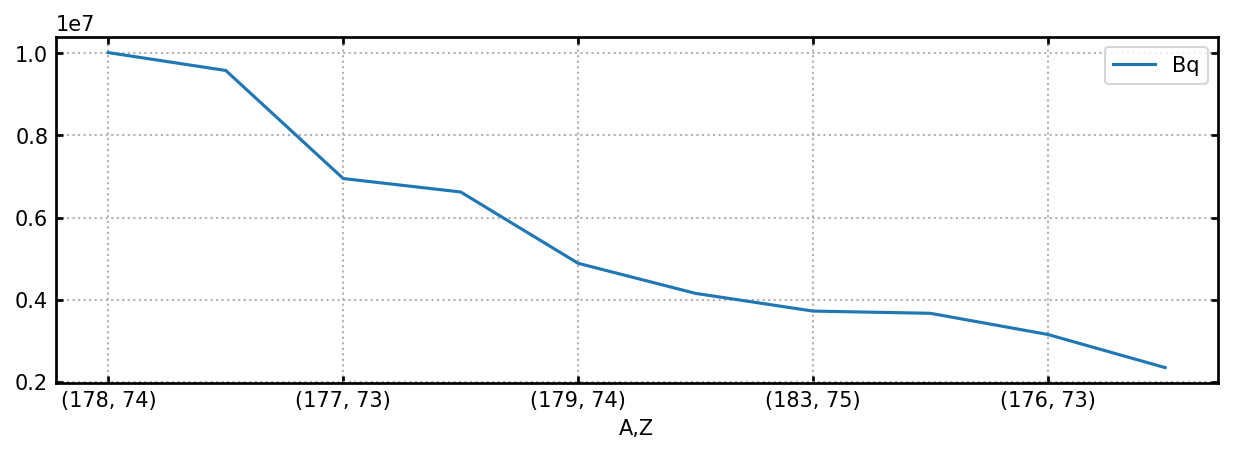

In [8]:
df_sums_tungsten[:10], df_sums_tungsten[:10].plot()

#### Halflife:  (64, 29) = 12.7 hours | (62, 29) = 9.67 min | (58, 27) = 70.86 days


(                 Bq
 A  Z               
 7  4   1.638900e+06
 61 29  1.556694e+06
 64 29  1.411397e+06
 62 29  1.356448e+06
 58 27  1.096000e+06
 11 6   9.050220e+05
 65 30  7.330000e+05
 63 30  6.250619e+05
 13 7   5.033022e+05
 62 30  4.709949e+05,
 <Axes: xlabel='A,Z'>)

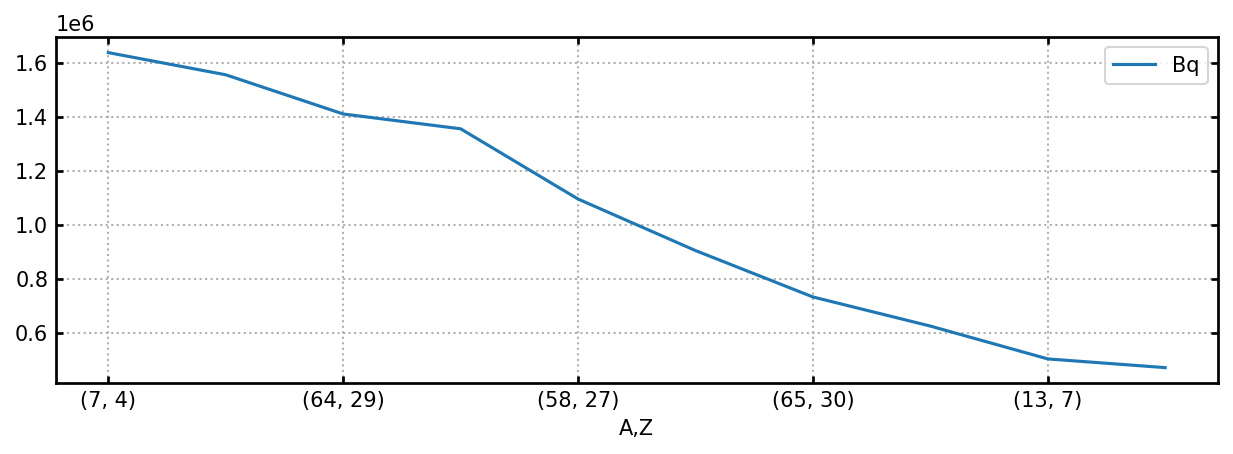

In [9]:
df_sums_brass[:10], df_sums_brass[:10].plot()

In [10]:
ff1, ff2 = get_df_sum(tungsten_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 160688


,A,Z,Bq
0,181,74,471000.0
1,178,74,446000.0
3,7,4,198000.0
2,183,75,180000.0


In [11]:
ff1, ff2 = get_df_sum(brass_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 27810


,A,Z,Bq
2,7,4,78200.0
0,58,27,53000.0
1,65,30,36300.0


In [12]:
ff1, ff2 = get_df_sum(brass_paths[18])
find_elements(ff1, ff1.max().mean()*10, True)

Cooling time = 150 Seconds | Threshold = 124029


,A,Z,Bq
0,62,29,265000.0
2,11,6,175000.0
1,61,29,148000.0
3,13,7,130000.0


In [13]:
ff1, ff2 = get_df_sum(tungsten_paths[18])
find_elements(ff1, ff1.max().mean()*10, True)

Cooling time = 150 Seconds | Threshold = 403030


,A,Z,Bq
1,179,74,662000.0
2,178,74,510000.0
0,181,74,480000.0
5,11,6,444000.0
3,181,75,434000.0
4,179,75,413000.0


In [19]:
tungsten_t, tungsten_sums, unc_tungsten_sums = get_val_unc(tungsten1p27_paths)
times_brass, sums_brass, unc_sums_brass = get_val_unc(brass1p25_paths)

In [20]:
def funlin(x, a, gamma, b):
    return a*np.exp(-gamma*x) + b

xlin = np.array(tungsten_t)

ylin = tungsten_sums

yler = unc_tungsten_sums

guess = [7e8, 0.00009, 2e8]

popt, pcov = curve_fit(funlin, xlin, ylin, p0=guess, sigma=yler, absolute_sigma=True)


print('a:',popt[0],'    gamma :',popt[1], "c : ",popt[2])
perr = np.sqrt(np.diag(pcov))
print('usikkerheder:',perr)
chmin = np.sum(((ylin-funlin(xlin, *popt))/yler)**2)
print("halflife = ", 1/popt[1]/60/60, " hours +-", (1/popt[1]**4*perr[1]**2)**(1/2)/60/60)

a: 3645709.671057668     gamma : 0.00016878916084781963 c :  2376738.5040751495
usikkerheder: [4.30512991e+04 5.07072924e-06 1.76592953e+04]
halflife =  1.6457086247867676  hours +- 0.04944003987670773


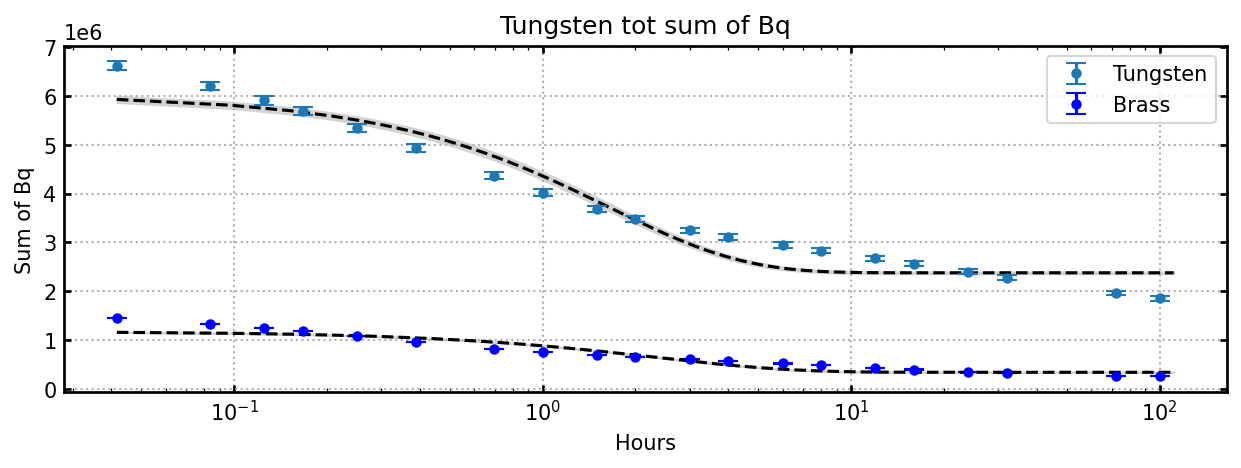

In [24]:
guess = [7e8, 0.00009, 2e8]
xs = np.linspace(150, 4e5, 2000)
#plt.plot(xs/60/60, funlin(xs, *guess))
plt.plot(xs/60/60, funlin(xs, *popt), "--", color="black")
plt.errorbar(np.array(tungsten_t)/60/60, tungsten_sums, yerr=unc_tungsten_sums, fmt="o", markersize=4, capsize=5, label="Tungsten")

plt.errorbar(np.array(times_brass)/60/60, sums_brass, yerr=unc_sums_brass, fmt="o", markersize=4, capsize=5, label="Brass", color="Blue")
plt.plot(xs/60/60, funlin(xs, *popt1), "--", color="black")

plt.fill_between(xs/60/60, funlin(xs, popt1[0]-perr1[0], popt1[1]+perr1[1], popt1[2]-perr1[2]),
                 funlin(xs, popt1[0]+perr1[0], popt1[1]-perr1[1], popt1[2]+perr1[2]), color="lightgrey")

plt.fill_between(xs/60/60, funlin(xs, popt[0]-perr[0], popt[1]+perr[1], popt[2]-perr[2]),
                 funlin(xs, popt[0]+perr[0], popt[1]-perr[1], popt[2]+perr[2]), color="lightgrey")

plt.title("Tungsten tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.xscale("log")
plt.legend()
plt.show()

In [22]:
def funlin(x, a, gamma, b):
    return a*np.exp(-gamma*x) + b

xlin = np.array(times_brass)

ylin = sums_brass

yler = unc_sums_brass

guess = [7e8, 0.00009, 2e8]

popt1, pcov1 = curve_fit(funlin, xlin, ylin, p0=guess, sigma=yler, absolute_sigma=True)


print('a:',popt1[0],'    gamma :',popt1[1], "c : ",popt1[2])
perr1 = np.sqrt(np.diag(pcov1))
print('usikkerheder:',perr1)
print("halflife = ", 1/popt1[1]/60/60, " hours +-", (1/popt1[1]**2*perr[1])/60/60 )

a: 834322.4113587835     gamma : 0.00011928861769968569 c :  336751.9134407858
usikkerheder: [8.86035292e+02 3.03078218e-07 3.02647864e+02]
halflife =  2.3286193027828985  hours +- 0.09898511872727984


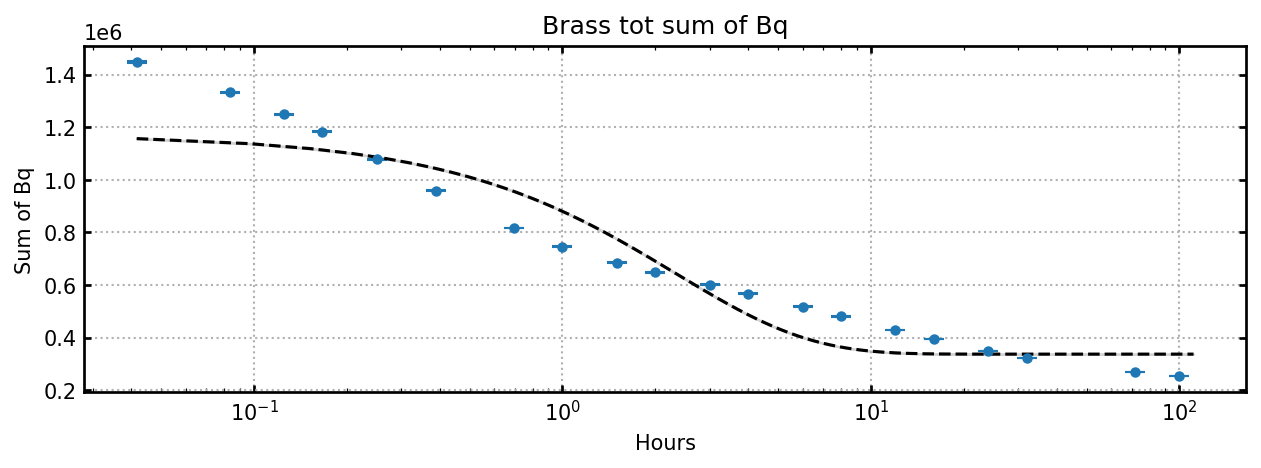

In [25]:
plt.errorbar(np.array(times_brass)/60/60, sums_brass, yerr=unc_sums_brass, fmt="o", markersize=4, capsize=5)
plt.plot(xs/60/60, funlin(xs, *popt1), "--", color="black")
plt.title("Brass tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.xscale("log")
plt.fill_between(xs/60/60, funlin(xs, popt1[0]-perr1[0], popt1[1]+perr1[1], popt1[2]-perr1[2]),
                 funlin(xs, popt1[0]+perr1[0], popt1[1]-perr1[1], popt1[2]+perr1[2]), color="lightgrey")
plt.show()
# exp fit half life overall 

In [ ]:
ff1, ff2 = get_df_sum(brass_paths[4])
plot_img(ff1, False, True)

In [ ]:
ff1, ff2 = get_df_sum(tungsten_paths[4])
plot_img(ff1, False, True)